# Imports and Tensorflow helper functions

In [ ]:
import collections
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, UpSampling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
import shutil
import csv
import json
import os
import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
# Plot an ROC. pred - the predictions, y - the expected output.

def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

%matplotlib inline    
from IPython.display import display 
from collections.abc import Sequence

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))

Load network intrusion data into a dataframe

In [3]:
network_intrusion_data = pd.read_csv("./network_intrusion_data.csv",na_values=['NA','?'])

# Add column labels

In [4]:
network_intrusion_data.columns = [
 'duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'outcome'
]

In [5]:
network_intrusion_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [6]:
network_intrusion_data.shape

(494020, 42)

<h1>Drop all redundant data from df</h1>

In [7]:
network_intrusion_data = network_intrusion_data.drop_duplicates()

In [8]:
network_intrusion_data.shape

(145585, 42)

# Data normalization

In [9]:
encode_text_dummy(network_intrusion_data, 'protocol_type')
encode_text_dummy(network_intrusion_data, 'service')
encode_text_dummy(network_intrusion_data, 'flag')
encode_numeric_zscore(network_intrusion_data, 'duration')
encode_numeric_zscore(network_intrusion_data, 'src_bytes')
encode_numeric_zscore(network_intrusion_data, 'dst_bytes')
encode_numeric_zscore(network_intrusion_data, 'wrong_fragment')
encode_numeric_zscore(network_intrusion_data, 'urgent')
encode_numeric_zscore(network_intrusion_data, 'hot')
encode_numeric_zscore(network_intrusion_data, 'num_failed_logins')
encode_numeric_zscore(network_intrusion_data, 'num_compromised')
encode_numeric_zscore(network_intrusion_data, 'root_shell')
encode_numeric_zscore(network_intrusion_data, 'su_attempted')
encode_numeric_zscore(network_intrusion_data, 'num_root')
encode_numeric_zscore(network_intrusion_data, 'num_file_creations')
encode_numeric_zscore(network_intrusion_data, 'num_shells')
encode_numeric_zscore(network_intrusion_data, 'num_access_files')
encode_numeric_zscore(network_intrusion_data, 'num_outbound_cmds')
encode_numeric_zscore(network_intrusion_data, 'count')
encode_numeric_zscore(network_intrusion_data, 'srv_count')
encode_numeric_zscore(network_intrusion_data, 'serror_rate')
encode_numeric_zscore(network_intrusion_data, 'srv_serror_rate')
encode_numeric_zscore(network_intrusion_data, 'rerror_rate')
encode_numeric_zscore(network_intrusion_data, 'srv_rerror_rate')
encode_numeric_zscore(network_intrusion_data, 'same_srv_rate')
encode_numeric_zscore(network_intrusion_data, 'diff_srv_rate')
encode_numeric_zscore(network_intrusion_data, 'srv_diff_host_rate')
encode_numeric_zscore(network_intrusion_data, 'dst_host_count')
encode_numeric_zscore(network_intrusion_data, 'dst_host_srv_count')
encode_numeric_zscore(network_intrusion_data, 'dst_host_same_srv_rate')
encode_numeric_zscore(network_intrusion_data, 'dst_host_diff_srv_rate')
encode_numeric_zscore(network_intrusion_data, 'dst_host_same_src_port_rate')
encode_numeric_zscore(network_intrusion_data, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(network_intrusion_data, 'dst_host_serror_rate')
encode_numeric_zscore(network_intrusion_data, 'dst_host_rerror_rate')
encode_numeric_zscore(network_intrusion_data, 'dst_host_srv_serror_rate')
encode_numeric_zscore(network_intrusion_data, 'dst_host_srv_rerror_rate')

#outcomes = lambda x: int(x != 'normal.')
#network_intrusion_data['outcome'] = network_intrusion_data['outcome'].apply(outcomes)
outcomes  = encode_text_index(network_intrusion_data, 'outcome')

print data after normalization

In [10]:
network_intrusion_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
0,-0.10785,-0.004261,-0.039036,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,...,0,0,0,0,0,0,0,0,1,0
1,-0.10785,-0.004263,-0.025041,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,...,0,0,0,0,0,0,0,0,1,0
2,-0.10785,-0.004272,-0.025041,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,...,0,0,0,0,0,0,0,0,1,0
3,-0.10785,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,...,0,0,0,0,0,0,0,0,1,0
4,-0.10785,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,...,0,0,0,0,0,0,0,0,1,0


# Fill n/a values

In [122]:
network_intrusion_data.fillna(0, inplace = True)

# Save Dataframe ready for testing

In [123]:
network_intrusion_data.to_csv ("./network_intrusion_data_ready.csv", index = False)

In [124]:
network_intrusion_data = pd.read_csv("./network_intrusion_data_ready.csv",na_values=['NA','?'])

# Create Train test Split for regressor

In [125]:
x,y = to_xy(network_intrusion_data,'outcome')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=45)

In [126]:
y.shape

(145585, 23)

In [127]:
x.shape

(145585, 118)

# Linear Regression regularization

Final score (RMSE): 0.041827376931905746


,coef,positive
is_host_login,-6.649953e+00,False
num_outbound_cmds,-6.443483e+00,False
is_guest_login,-3.305793e-01,False
num_root,-1.404925e-01,False
rerror_rate,-8.858732e-02,False
dst_host_srv_count,-6.038205e-02,False
serror_rate,-5.298581e-02,False
dst_host_serror_rate,-3.206378e-02,False
land,-2.279612e-02,False
dst_host_srv_rerror_rate,-1.803403e-02,False


Intercept: -32.86921310424805


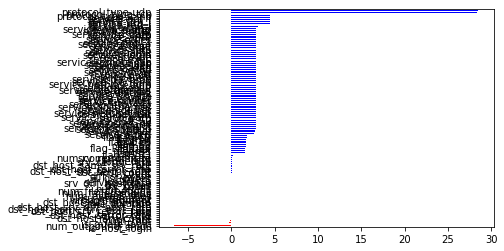

In [128]:
from sklearn.linear_model import Lasso

# Create linear regression
regressor = LinearRegression()

# Fit/train ElasticNet
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(network_intrusion_data.columns.values)
names.remove('outcome')
report_coef(
   names,
   regressor.coef_[0],
   regressor.intercept_[0])

In [129]:
regressor.intercept_[0]

-32.869213

In [130]:
regressor.coef_

array([[-3.00383521e-03, -1.06965424e-04,  2.97988765e-04, ...,
         1.58174288e+00,  1.59444571e+00,  1.71466947e+00],
       [-9.53336930e-05, -3.15229263e-05, -2.58043146e-04, ...,
        -3.81417461e-02, -3.36432941e-02, -3.24881412e-02],
       [-3.92135516e-05,  2.93225821e-06, -3.79106787e-05, ...,
         4.02503237e-02,  4.07967903e-02,  3.91797535e-02],
       ...,
       [-1.79682422e-04, -7.32425833e-05, -1.94283202e-05, ...,
        -4.75839376e-01, -4.63976055e-01, -4.83356684e-01],
       [ 4.76388028e-03,  5.21360897e-04, -1.69370323e-03, ...,
         1.10095441e-01,  2.50777230e-02,  7.87930191e-02],
       [-4.28746316e-05,  6.63740138e-06,  8.80321022e-03, ...,
         6.65993523e-03,  4.66151070e-03,  5.45030087e-03]], dtype=float32)

# create x and y for testing

In [132]:
x,y = to_xy(network_intrusion_data,'outcome')

# Create train test split for cnn

In [133]:
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.25, random_state=45)

# Reshape for CNN

In [134]:
img_rows, img_cols = 1, x.shape[1]
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

(109188, 1, 118, 1)
(109188, 23)


In [135]:
print(x_train.shape)
print(x_test.shape)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))

(109188, 1, 118, 1)
(36397, 1, 118, 1)
x_train shape: (109188, 1, 118, 1)
x_test shape: (36397, 1, 118, 1)
Training samples: 109188
Test samples: 36397


In [136]:
print(y_train.shape)
print(y_train[:10])

(109188, 23)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


print out the categorical y_trai and y_test as a dataframe

In [137]:
pd.DataFrame(y_train).head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
pd.DataFrame(y_test).head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
y_train.shape, y_test.shape

((109188, 23), (36397, 23))

# CNN


In [213]:
model = Sequential()
mode = 'relu'
input_shape = (img_rows, img_cols, 1)

model.add(Conv2D(64, kernel_size=(1, 5), strides=(1, 1), padding='valid',
                 activation=mode,
                 input_shape=input_shape,
                 kernel_regularizer=l2(0.01),
                 bias_regularizer=l2(0.01)))

model.add(MaxPooling2D(pool_size=(1, 4), strides=None))
model.add(Dropout(0.25)) 

num_classes = 23
model.add(Flatten())
model.add(Dense(128, activation=mode))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 1, 114, 64)        384       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 1, 28, 64)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 28, 64)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1792)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               229504    
_________________________________________________________________
dense_37 (Dense)             (None, 23)                2967      
Total params: 232,855
Trainable params: 232,855
Non-trainable params: 0
_______________________________________________

Compile Model

In [214]:

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001,beta_1=0.9, beta_2=0.999,  decay=1e-3, epsilon=None, amsgrad = True), metrics=['accuracy'])

In [ ]:
import time

start_time = time.time()
batch_size = 128

monitor = EarlyStopping(monitor='val_loss', min_delta =1e-5, patience=5, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath="./best_weights.hdf5", verbose=0, save_best_only=True) # save best model
model.fit(x_train, y_train,     
          batch_size=batch_size,
          epochs=100,
          verbose=2,
          callbacks = [monitor,checkpointer],
          validation_data=(x_test, y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Train on 109188 samples, validate on 36397 samples
Epoch 1/100
109188/109188 - 11s - loss: 0.1059 - acc: 0.9836 - val_loss: 0.0425 - val_acc: 0.9948
Epoch 2/100
109188/109188 - 11s - loss: 0.0349 - acc: 0.9941 - val_loss: 0.0334 - val_acc: 0.9949
Epoch 3/100
109188/109188 - 12s - loss: 0.0287 - acc: 0.9952 - val_loss: 0.0289 - val_acc: 0.9960
Epoch 4/100
109188/109188 - 12s - loss: 0.0259 - acc: 0.9954 - val_loss: 0.0273 - val_acc: 0.9961
Epoch 5/100
109188/109188 - 12s - loss: 0.0240 - acc: 0.9959 - val_loss: 0.0258 - val_acc: 0.9963
Epoch 6/100
109188/109188 - 11s - loss: 0.0231 - acc: 0.9959 - val_loss: 0.0256 - val_acc: 0.9962
Epoch 7/100
109188/109188 - 11s - loss: 0.0223 - acc: 0.9961 - val_loss: 0.0246 - val_acc: 0.9965
Epoch 8/100
109188/109188 - 13s - loss: 0.0215 - acc: 0.9963 - val_loss: 0.0246 - val_acc: 0.9964
Epoch 9/100
109188/109188 - 11s - loss: 0.0209 - acc: 0.9966 - val_loss: 0.0241 - val_acc: 0.9964
Epoch 10/100
109188/109188 - 11s - loss: 0.0207 - acc: 0.9965 - val

In [76]:
model.load_weights('./best_weights.hdf5') # load weights from best model


In [169]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.013857809275354148
Test accuracy: 0.9976646304130554


# Print out precision, recall, f1 and support

In [80]:

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)


score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

Accuracy: 0.9976646426903316
Averaged F1: 0.9975604067827032
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       246
           1       0.78      0.78      0.78         9
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00        11
           4       1.00      0.67      0.80         3
           5       0.95      0.97      0.96       151
           6       1.00      1.00      1.00         3
           7       0.50      0.50      0.50         2
           8       0.00      0.00      0.00         4
           9       1.00      1.00      1.00     12981
          10       0.93      0.90      0.92        42
          11       1.00      1.00      1.00     21960
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00        50
          15       0.99      0.98      0.99       103
          16       0

D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Plot confusion matrix

[[  242     0     0     0     0     0     0     0     0     0     0     4
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     7     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     2     0]
 [    0     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0    11     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    1     0     0     0     2     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   146     0     0     0     0     2     3
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     3     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]

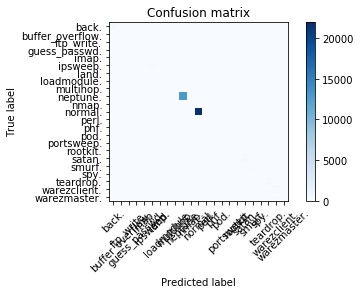

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       246
           1       0.78      0.78      0.78         9
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00        11
           4       1.00      0.67      0.80         3
           5       0.95      0.97      0.96       151
           6       1.00      1.00      1.00         3
           7       0.50      0.50      0.50         2
           8       0.00      0.00      0.00         4
           9       1.00      1.00      1.00     12981
          10       0.93      0.90      0.92        42
          11       1.00      1.00      1.00     21960
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00        50
          15       0.99      0.98      0.99       103
          16       0.00      0.00      0.00         3
          17       1.00    

In [81]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcomes)
plt.show()


print(classification_report(y_true, pred))

# Fully Connected Model

In [82]:
df=pd.read_csv("./network_intrusion_data_ready.csv",na_values=['NA','?'])
#outcome = encode_text_index(df,"outcome")


In [83]:
x,y = to_xy(df,"outcome")

In [84]:
x

array([[-0.10785025, -0.00426104, -0.03903572, ...,  0.        ,
         1.        ,  0.        ],
       [-0.10785025, -0.00426324, -0.02504131, ...,  0.        ,
         1.        ,  0.        ],
       [-0.10785025, -0.00427203, -0.02504131, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.10785025, -0.00428082, -0.02729423, ...,  0.        ,
         1.        ,  0.        ],
       [-0.10785025, -0.00423248, -0.02729423, ...,  0.        ,
         1.        ,  0.        ],
       [-0.10785025, -0.00427203, -0.02673511, ...,  0.        ,
         1.        ,  0.        ]], dtype=float32)

In [85]:
x.shape

(145585, 118)

In [86]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [87]:
y.shape

(145585, 23)

# Create Model

In [88]:
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(y.shape[1], activation='softmax')) # Output
batch = 128
epo = 100
model.compile(loss='categorical_crossentropy', optimizer='adam')
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.20, random_state = 42)
monitor = EarlyStopping(monitor='val_loss', min_delta =1e-5, patience=5, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath="./fully_mapped.hdf5", verbose=0, save_best_only=True) # save best model
model.fit(x_train,y_train,validation_data = (x_test,y_test),batch_size = batch,callbacks = [monitor,checkpointer],verbose=2,epochs=epo)


Train on 116468 samples, validate on 29117 samples
Epoch 1/5
116468/116468 - 2s - loss: 0.1834 - val_loss: 0.0212
Epoch 2/5
116468/116468 - 2s - loss: 0.0163 - val_loss: 0.0148
Epoch 3/5
116468/116468 - 2s - loss: 0.0122 - val_loss: 0.0138
Epoch 4/5
116468/116468 - 2s - loss: 0.0101 - val_loss: 0.0117
Epoch 5/5
116468/116468 - 2s - loss: 0.0088 - val_loss: 0.0175


In [89]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                5950      
_________________________________________________________________
dense_8 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_9 (Dense)              (None, 23)                598       
Total params: 7,823
Trainable params: 7,823
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.load_weights('./fully_mapped.hdf5') # load weights from best model


# Plot Confusion Matrix

[[  190     0     0     0     0     0     0     0     0     0     1     0
      0     0     0     0     0     0     0]
 [    0     1     0     0     0     0     0     0     0     0     4     0
      0     0     0     0     0     1     0]
 [    0     0     0     0     0     0     0     0     0     0     3     0
      0     0     0     0     0     2     0]
 [    0     0     0    10     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     1     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0   133     0     0     0     2     2     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     2     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     2     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     

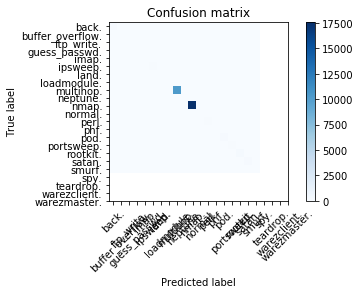

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       191
           1       1.00      0.17      0.29         6
           2       0.00      0.00      0.00         5
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         1
           5       0.95      0.97      0.96       137
           6       1.00      1.00      1.00         2
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00     10357
          10       0.94      0.79      0.86        38
          11       1.00      1.00      1.00     17589
          14       1.00      1.00      1.00        34
          15       0.99      0.98      0.98        92
          16       0.00      0.00      0.00         1
          17       1.00      0.98      0.99       158
          18       1.00      0.98      0.99       132
          20       1.00      1.00      1.00       208
          21       0.93    

D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [91]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcomes)
plt.show()


print(classification_report(y_true, pred))